In [1]:
from kafka import KafkaConsumer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from json import dumps
import numpy as np
import pickle
from sklearn.metrics import classification_report,accuracy_score

import pickle


In [2]:
from kafka import KafkaConsumer

In [3]:
consumer = KafkaConsumer(
    'ml-raw-dns',
    bootstrap_servers="localhost:9092",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)


In [4]:

for m in consumer:
    m.value
    break

# Reading the data 

In [5]:
count = 0
for m in consumer:
    if count < 1000:
        print(m.value)
        count += 1
    else:
        break


b'"56:19.8,27,10,0,10,11,2.57041707,6,6,7,3.666666667,2,192,14,1,1\\n"'
b'"07:23.9,27,10,0,10,11,2.767194749,6,6,7,3.666666667,2,192,14,1,1\\n"'
b'"23:15.1,26,9,0,10,10,2.742337624,6,6,7,3.5,2,192,13,1,0\\n"'
b'"04:51.9,27,10,0,10,11,2.57041707,6,6,7,3.666666667,2,192,14,1,1\\n"'
b'"12:44.0,15,9,0,11,0,2.929438722,4,3,5,4.333333333,local,local,15,1,1\\n"'
b'"16:29.5,27,10,0,10,11,2.57041707,6,6,7,3.666666667,2,192,14,1,1\\n"'
b'"26:58.3,23,3,0,20,0,3.568087315,3,3,16,7,pforzheim,pforzheim-bisons,20,1,0\\n"'
b'"57:29.2,24,7,0,10,8,2.054028744,6,6,7,3.166666667,4,224,11,1,1\\n"'
b'"27:59.6,14,3,0,12,0,2.514246535,2,3,6,4,face,reface,10,1,0\\n"'
b'"21:27.9,18,0,0,17,0,2.879112889,1,2,14,8.5,store,dellogliostore,15,0,0\\n"'
b'"09:54.6,24,7,0,10,8,2.054028744,6,6,7,3.166666667,4,224,11,1,0\\n"'
b'"40:01.6,21,0,0,19,0,3.451879862,2,2,17,10,kate,katekyo-fukushima,18,0,0\\n"'
b'"50:01.3,24,7,0,10,8,2.054028744,6,6,7,3.166666667,4,224,11,1,1\\n"'
b'"17:54.6,24,7,0,10,8,2.054028744,6,6,7,3.16666

# Function to read only the first 1000 row from the data 

In [7]:
def get_1000_rec(itr):
    list_of_1000_rec=[]
    i=0
    for c in consumer:

        if i <1000:
            list_of_1000_rec.append(c.value)
            i=i+1
        else:

            break
    print(f"Window {itr}")


    return list_of_1000_rec


In [8]:
test1=get_1000_rec(0)

Window 0


In [9]:

col_names =['timestamp','FQDN_count', 'subdomain_length', 'upper', 'lower', 'numeric',
       'entropy', 'special', 'labels', 'labels_max', 'labels_average',
       'longest_word', 'sld', 'len', 'subdomain', 'Target Attack']
def adjust_data( data):
    dataframe=pd.DataFrame()
    list_of_rows=[]
    for item in data:
        row_string=eval(item.decode("UTF-8"))
        row_string = row_string.strip()
        row= row_string.split(",")
        list_of_rows.append(row)
    dataframe=pd.DataFrame(list_of_rows)
    dataframe.columns=col_names
    return dataframe

In [10]:
final1=adjust_data(test1)

In [11]:
final1

,timestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Target Attack
0,50:43.6,26,9,0,10,10,2.742337624,6,6,7,3.5,2,192,13,1,1
1,35:36.0,14,0,0,13,0,2.786215626,1,2,11,6.5,insight,techinsight,12,0,0
2,22:33.1,24,7,0,10,8,2.054028744,6,6,7,3.166666667,4,224,11,1,1
3,29:59.7,17,0,0,15,0,2.392543856,2,2,13,8,silica,silica-silica,14,0,0
4,46:22.0,27,10,0,10,11,2.767194749,6,6,7,3.666666667,2,192,14,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,03:44.8,26,9,0,10,10,2.742337624,6,6,7,3.5,2,192,13,1,0
996,42:22.3,2,0,2,0,0,1.056641667,0,1,2,2,C,DC,3,0,1
997,59:49.3,24,7,0,10,8,2.054028744,6,6,7,3.166666667,4,224,11,1,1
998,55:57.2,24,7,0,10,8,2.054028744,6,6,7,3.166666667,4,224,11,1,1


In [12]:
import pandas as pd
def convert_non_numeric_to_mode(df, columns_to_check=['longest_word', 'sld']):
    for column in columns_to_check:
        # Calculate the mode for the current column
        mode_value = df[column].mode()[0]

        # Use a lambda function to replace non-numeric values with the mode value
        df[column] = df[column].apply(lambda x: mode_value if not str(x).isnumeric() else x)

    return df
columns_to_check = ['longest_word', 'sld']
result_df = convert_non_numeric_to_mode(final1, columns_to_check)


In [13]:
result_df

,timestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Target Attack
0,50:43.6,26,9,0,10,10,2.742337624,6,6,7,3.5,2,192,13,1,1
1,35:36.0,14,0,0,13,0,2.786215626,1,2,11,6.5,2,192,12,0,0
2,22:33.1,24,7,0,10,8,2.054028744,6,6,7,3.166666667,4,224,11,1,1
3,29:59.7,17,0,0,15,0,2.392543856,2,2,13,8,2,192,14,0,0
4,46:22.0,27,10,0,10,11,2.767194749,6,6,7,3.666666667,2,192,14,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,03:44.8,26,9,0,10,10,2.742337624,6,6,7,3.5,2,192,13,1,0
996,42:22.3,2,0,2,0,0,1.056641667,0,1,2,2,2,192,3,0,1
997,59:49.3,24,7,0,10,8,2.054028744,6,6,7,3.166666667,4,224,11,1,1
998,55:57.2,24,7,0,10,8,2.054028744,6,6,7,3.166666667,4,224,11,1,1


In [14]:
def cleaning_the_data(data):
    data.dropna(inplace=True)
    data.drop('timestamp', inplace=True, axis=1)
    selected_features = ['FQDN_count', 'subdomain_length', 'upper', 'lower', 'numeric', 'special', 'labels', 'sld', 'len', 'subdomain','Target Attack']
    data1= data.copy()
    data1= data[selected_features]
    return data1.astype(float)

In [15]:
final=cleaning_the_data(result_df)

In [16]:
final

,FQDN_count,subdomain_length,upper,lower,numeric,special,labels,sld,len,subdomain,Target Attack
0,26.0,9.0,0.0,10.0,10.0,6.0,6.0,192.0,13.0,1.0,1.0
1,14.0,0.0,0.0,13.0,0.0,1.0,2.0,192.0,12.0,0.0,0.0
2,24.0,7.0,0.0,10.0,8.0,6.0,6.0,224.0,11.0,1.0,1.0
3,17.0,0.0,0.0,15.0,0.0,2.0,2.0,192.0,14.0,0.0,0.0
4,27.0,10.0,0.0,10.0,11.0,6.0,6.0,192.0,14.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
995,26.0,9.0,0.0,10.0,10.0,6.0,6.0,192.0,13.0,1.0,0.0
996,2.0,0.0,2.0,0.0,0.0,0.0,1.0,192.0,3.0,0.0,1.0
997,24.0,7.0,0.0,10.0,8.0,6.0,6.0,224.0,11.0,1.0,1.0
998,24.0,7.0,0.0,10.0,8.0,6.0,6.0,224.0,11.0,1.0,1.0


In [17]:
# def retrain(data):

#     pipe = Pipeline(steps=[("MI with RF",SelectKBest(score_func=mutual_info_classif, k=10)), ("RandomForestClassifier", RandomForestClassifier())])
#     X =data.drop(labels = ["Target Attack"], axis=1)
#     y=data["Target Attack"]
#     pipe.fit(X,y)
#     return pipe

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier

def retrain(data):
    selected_X_train = data.drop(labels = ["Target Attack"], axis=1)
    y_train= data["Target Attack"]
    feature_selection = SelectKBest(chi2, k=10)
    rf_classifier = RandomForestClassifier(random_state=42, max_depth=None, n_estimators=100, criterion='gini')

    pipeline = Pipeline([
        ('feature_selection', feature_selection),
        ('classifier', rf_classifier)
    ])

    pipeline.fit(selected_X_train, y_train)
    return pipeline


In [19]:
pickle.load(open('mutual_info_rf_model.pkl', 'rb'))

Pipeline(steps=[('feature_selection',
                 SelectKBest(score_func=<function chi2 at 0x00000162CBD9A160>)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [20]:
static_model = Dynamic_model= pickle.load(open('mutual_info_rf_model.pkl', 'rb'))

In [21]:
training_data=cleaning_the_data(convert_non_numeric_to_mode(adjust_data(get_1000_rec(0))))
list_of_f1_Dynmaic_model=[]
list_of_f1_static_model=[]
for itr in range(1,100):
    r_dataset = get_1000_rec(itr)
    p_dataset =  adjust_data(r_dataset)
    new_dataset =  cleaning_the_data(convert_non_numeric_to_mode(p_dataset))
    X =new_dataset.drop(labels = ["Target Attack"], axis=1)
    y=new_dataset["Target Attack"]

    Dy_pred=Dynamic_model.predict(X)
    D_f1=accuracy_score(y,Dy_pred)
    print(f"The F1 Score of Dynamic Model without retrain = {D_f1*100}%")
    if D_f1 < 0.815 :

        print(" trained model on the new data")
        Dynamic_model=retrain(training_data)
        Dy_pred=Dynamic_model.predict(X)
        D_f1=accuracy_score(y,Dy_pred)
        print(f"The f1 of Dynamic Model after retrain = {D_f1*100}%")
    training_data=pd.concat([training_data,new_dataset])
    Sy_pred=static_model.predict(X)
    S_f1=accuracy_score(y,Sy_pred)
    print(f"The F1 of Static Model = {S_f1*100}%")
    list_of_f1_Dynmaic_model.append(D_f1)
    list_of_f1_static_model.append(S_f1)
    print(f"{'*'*10}")


Window 0
Window 1
The F1 Score of Dynamic Model without retrain = 83.3%
The F1 of Static Model = 83.3%
**********
Window 2
The F1 Score of Dynamic Model without retrain = 82.8%
The F1 of Static Model = 82.8%
**********
Window 3
The F1 Score of Dynamic Model without retrain = 80.0%
 trained model on the new data
The f1 of Dynamic Model after retrain = 80.2%
The F1 of Static Model = 80.0%
**********
Window 4
The F1 Score of Dynamic Model without retrain = 80.2%
 trained model on the new data
The f1 of Dynamic Model after retrain = 80.2%
The F1 of Static Model = 80.2%
**********
Window 5
The F1 Score of Dynamic Model without retrain = 84.39999999999999%
The F1 of Static Model = 84.5%
**********
Window 6
The F1 Score of Dynamic Model without retrain = 84.0%
The F1 of Static Model = 84.0%
**********
Window 7
The F1 Score of Dynamic Model without retrain = 81.8%
The F1 of Static Model = 81.89999999999999%
**********
Window 8
The F1 Score of Dynamic Model without retrain = 81.2%
 trained mode

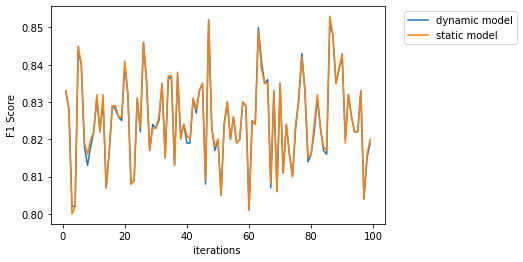

In [23]:
import matplotlib.pyplot as plt
plt.plot(range(1, 100), list_of_f1_Dynmaic_model, label=f'dynamic model')
plt.plot(range(1, 100),list_of_f1_static_model, label=f'static model')
plt.xlabel('iterations ')
plt.ylabel("F1 Score")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

In [ ]:

# Call the function to convert the data to a DataFrame
result_df = get_first_1000_as_dataframe(consumer)


In [ ]:
result_df

In [ ]:
result_df.info()